# Индекс поиска

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')

from sklearn.decomposition import PCA

%matplotlib inline

###  Описание:

Индекс строится на основе кризисных дескрипторов, взятых из [статьи Столбова.](https://yadi.sk/i/T24TXCw2Jzy8oQ)  Автор посмотрел, что активнее всего гуглилось по категории "Финансы и страхование" в пик кризиса 2008 года. Он отобрал эти дескрипторы и разбавил их ещё несколькими терминами. 

###  Технические особенности: 

Скачиваем поисковые запросы по всем дескрипторам Столбова. Можно и руками, но для больших объёмов поисковой скачки, есть [рекурсивный парсер.](https://nbviewer.jupyter.org/github/FUlyankin/Parsers/blob/master/Parsers%20/google_trends_selenium_parser.ipynb) Индекс будем строить двумя способами:

- взвесив все слова с коэффицентами  

$$
w_i = \frac{\sum_{j} r_{ij}}{\sum_{i,j} r_{ij}}
$$

- взяв одну из компонент PCA-разложения. Брать будем не первую компоненту, а ту компоненту, которая улавливает в себе "пики". В нашем случае это вторая компонента.

In [2]:
!ls ../01_Google_trends_parser

chromedriver                  krizis_poisk_month.tsv
google_selenium_parser.ipynb  krizis_poisk_odinar_month.tsv


In [3]:
def index_make(df_term):
    corr_matrix = df_term.corr()
    w = np.array(corr_matrix.sum()/corr_matrix.sum().sum())
    print(w)
    index = (np.array(df_term).T*w.reshape(len(w),1)).sum(axis = 0)
    mx = index.max()
    mn = index.min()
    return 100*(index - mn)/(mx - mn)

def min_max_scaler(df, col):
    mx = df[col].max()
    mn = df[col].min()
    df[col] = 100*(df[col] - mn)/(mx - mn)
    pass

In [4]:
path = '../01_Google_trends_parser/krizis_poisk_odinar_month.tsv'

df_poisk = pd.read_csv(path, sep='\t')
df_poisk.set_index('Месяц', inplace=True)
print(df_poisk.shape)

df_pi = pd.DataFrame() 
df_pi['fielddate'] = df_poisk.index

index_poisk = index_make(df_poisk)
df_pi['poiskInd_ind_corr'] = index_poisk

model_pca = PCA(n_components= 15)
model_pca.fit(df_poisk)
df_pi_pca = model_pca.transform(df_poisk)

# plt.plot(model_pca.explained_variance_, label='Component variances')
# plt.xlabel('n components')
# plt.ylabel('variance')
# plt.legend(loc='upper right');

df_pi['poiskInd_ind_pca'] = list(df_pi_pca[:,1])
min_max_scaler(df_pi, 'poiskInd_ind_pca')

(204, 15)
[ 0.08446643  0.09496884  0.10277963  0.08112792  0.08446381  0.06287401
  0.04195086  0.05451163  0.07188251  0.04230182 -0.01090201  0.0296453
  0.0587021   0.10535107  0.09587608]


In [5]:
# copy paste (((
path = '../01_Google_trends_parser/krizis_poisk_month.tsv'

df_poisk = pd.read_csv(path, sep='\t')
df_poisk.set_index('Месяц', inplace=True)
print(df_poisk.shape)

index_poisk = index_make(df_poisk)
df_pi['poiskInd_corr'] = index_poisk

model_pca = PCA(n_components= 15)
model_pca.fit(df_poisk)
df_pi_pca = model_pca.transform(df_poisk)

df_pi['poiskInd_pca'] = list(df_pi_pca[:,1])
min_max_scaler(df_pi, 'poiskInd_pca')

(204, 15)
[ 0.10441591  0.11182445  0.0901172   0.09793395  0.0822192   0.09229819
  0.06784256  0.045034    0.04942101  0.06205676  0.02045176 -0.00065897
  0.03715745  0.03763966  0.10224687]


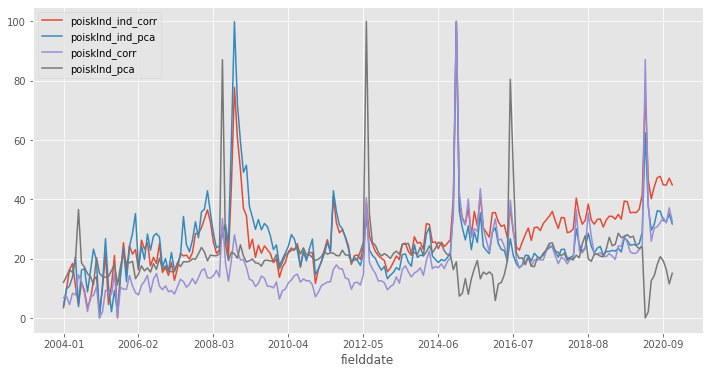

In [6]:
df_pi.set_index('fielddate').plot(legend=True, figsize=(12,6));

--------

In [7]:
df_pi.to_csv('data_simple_index_v2/poisk_krizis_index_month.tsv', sep="\t", index=None)

-------------